In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [85]:
# Load Data
company = "FB"

In [86]:
start= dt.datetime(2015,1,1)
end = dt.datetime(2021,1,1)

In [87]:
data= web.DataReader(company, "yahoo", start, end)

In [88]:
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-29,163.050003,159.009995,160.660004,159.169998,20052700,159.169998
2022-08-30,161.660004,155.910004,160.350006,157.160004,19567900,157.160004
2022-08-31,167.839996,162.139999,167.070007,162.929993,40953000,162.929993
2022-09-01,167.360001,160.350006,163.580002,165.360001,30145700,165.360001
2022-09-02,167.929993,159.220001,167.449997,160.320007,22609100,160.320007


In [89]:
# Prepare Data
scaler= MinMaxScaler(feature_range=(0,1))
scaled_data= scaler.fit_transform(data["Close"].values.reshape(-1,1))

In [90]:
pred_days= 60

In [91]:
x_train= []
y_train= []

In [92]:
for x in range(pred_days, len(scaled_data)):
    x_train.append(scaled_data[x-pred_days : x, 0])
    y_train.append(scaled_data[x,0])

In [93]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [94]:
x_train= np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build The Model

In [95]:
model= Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=1)) # Prediction of the next closing value

model.compile(optimizer="adam", loss="mean_squared_error")

model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
6/6 [==============================] - 4s 34ms/step - loss: 0.1146
Epoch 2/25
6/6 [==============================] - 0s 33ms/step - loss: 0.0402
Epoch 3/25
6/6 [==============================] - 0s 33ms/step - loss: 0.0266
Epoch 4/25
6/6 [==============================] - 0s 34ms/step - loss: 0.0191
Epoch 5/25
6/6 [==============================] - 0s 34ms/step - loss: 0.0150
Epoch 6/25
6/6 [==============================] - 0s 35ms/step - loss: 0.0159
Epoch 7/25
6/6 [==============================] - 0s 33ms/step - loss: 0.0119
Epoch 8/25
6/6 [==============================] - 0s 33ms/step - loss: 0.0121
Epoch 9/25
6/6 [==============================] - 0s 34ms/step - loss: 0.0102
Epoch 10/25
6/6 [==============================] - 0s 34ms/step - loss: 0.0108
Epoch 11/25
6/6 [==============================] - 0s 39ms/step - loss: 0.0106
Epoch 12/25
6/6 [==============================] - 0s 38ms/step - loss: 0.0093
Epoch 13/25
6/6 [==============================] - 0s 34ms/st

# Test The Model Accuracy on Existing Data

In [96]:
# Load Test Data
test_start= dt.datetime(2021,1,1)
test_end= dt.datetime.now()

In [97]:
test_data= web.DataReader(company, "yahoo", test_start, test_end)

In [98]:
test_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-09-03,377.160004,373.109985,374.750000,376.260010,7509600,376.260010
2021-09-07,382.959991,373.149994,375.880005,382.179993,10793800,382.179993
2021-09-08,380.869995,374.790009,380.160004,377.570007,11067200,377.570007
2021-09-09,379.829987,376.570007,377.640015,378.000000,9098900,378.000000
2021-09-10,383.790009,378.260010,381.359985,378.690002,11549600,378.690002


In [99]:
actual_prices= test_data["Close"].values

In [100]:
total_dataset= pd.concat((data["Close"], test_data["Close"]), axis=0)

In [101]:
model_inputs= total_dataset[len(total_dataset) - len(test_data) - pred_days:].values

In [102]:
model_inputs= model_inputs.reshape(-1, 1)

In [103]:
model_inputs= scaler.transform(model_inputs)

# Make Predictions on Test Data

In [104]:
x_test= []

In [105]:
for x in range(pred_days, len(model_inputs)):
    x_test.append(model_inputs[x - pred_days : x, 0])

x_test= np.array(x_test)
x_test= np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

pred_prices= model.predict(x_test)
pred_prices= scaler.inverse_transform(pred_prices)

# Plot The Test Predictions

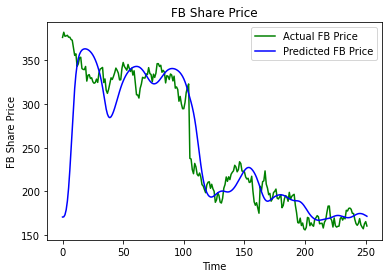

In [106]:
plt.plot(actual_prices, color="green", label= f"Actual {company} Price")
plt.plot(pred_prices, color= "blue", label= f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()

# Predict Next Day

In [111]:
real_data= [model_inputs[len(model_inputs) - pred_days: len(model_inputs+1), 0]]
real_data= np.array(real_data)
real_data= np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [112]:
prediction= model.predict(real_data)
prediction= scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[170.61542]]
